# Statistical model

/Users/elsa/anaconda3/envs/dmenv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


                              OLS Regression Results                              
Dep. Variable:     Q("NAG/total_biomass")   R-squared:                       0.504
Model:                                OLS   Adj. R-squared:                  0.488
Method:                     Least Squares   F-statistic:                     31.16
Date:                    Thu, 05 Sep 2024   Prob (F-statistic):           5.45e-14
Time:                            11:36:45   Log-Likelihood:                 89.111
No. Observations:                      96   AIC:                            -170.2
Df Residuals:                          92   BIC:                            -160.0
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

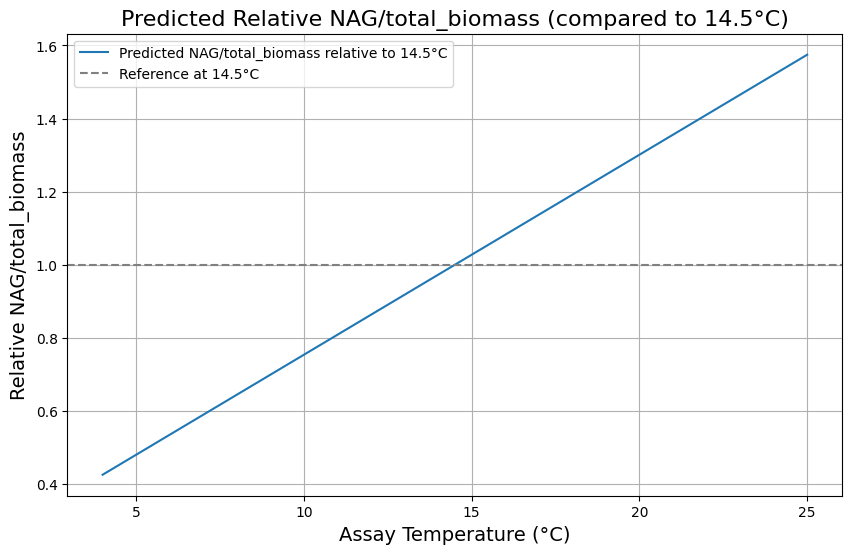

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
from scipy.stats import t

# Load the data
data = pd.read_excel("./enzyme_activity_combined.xlsx")

# Filter and prepare the data for each sample containing '-4+', '-11+', '-18+', and '-25+'
samples = ['-4+', '-11+', '-18+', '-25+']
incub_temps = [4, 11, 18, 25]

filtered_data = []

for sample, incub_temp in zip(samples, incub_temps):
    temp_data = data[data['sample'].str.contains(f'{sample}') & ~data['sample'].str.contains(f'{sample[:-1]}-')]
    temp_data = temp_data[['assay_temp', 'NAG', 'total_biomass']]
    temp_data['NAG'] = temp_data['NAG'].apply(lambda x: max(x, 0))
    temp_data['incub_temp'] = incub_temp
    temp_data['NAG/total_biomass'] = temp_data['NAG'] / temp_data['total_biomass']
    filtered_data.append(temp_data)

# Combine the filtered data
combined_data = pd.concat(filtered_data)

# Build the statistical model using Ordinary Least Squares (OLS)
# Including interaction between assay_temp and incub_temp
model = smf.ols(formula='Q("NAG/total_biomass") ~ assay_temp * incub_temp', data=combined_data).fit()

# Summarize the model results
print(model.summary())

# Calculate the mean of the incubation temperatures
mean_incub_temp = np.mean(incub_temps)

# Create a new dataframe for temperatures between 4 and 25°C, including the mean incubation temperature (14.5°C)
temp_range = np.linspace(4, 25, 100)

# Create a dataframe for predictions at each incubation temperature
pred_data = pd.DataFrame({
    'assay_temp': temp_range,
    'incub_temp': [mean_incub_temp] * len(temp_range)
})

# Get predictions from the model for this temperature range
predicted_values = model.predict(pred_data)

# Calculate the predicted value at the mean temperature (14.5°C) for comparison
pred_data_mean = pd.DataFrame({
    'assay_temp': [mean_incub_temp],
    'incub_temp': [mean_incub_temp]
})

predicted_value_at_mean = model.predict(pred_data_mean)[0]

# Calculate the relative change compared to the prediction at 14.5°C
relative_change = predicted_values / predicted_value_at_mean

# Plot the relative change
plt.figure(figsize=(10, 6))
plt.plot(temp_range, relative_change, label='Predicted NAG/total_biomass relative to 14.5°C')
plt.axhline(y=1, color='gray', linestyle='--', label='Reference at 14.5°C')
plt.xlabel('Assay Temperature (°C)', fontsize=14)
plt.ylabel('Relative NAG/total_biomass', fontsize=14)
plt.title('Predicted Relative NAG/total_biomass (compared to 14.5°C)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Add eco-evo model prediction

/Users/elsa/anaconda3/envs/dmenv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


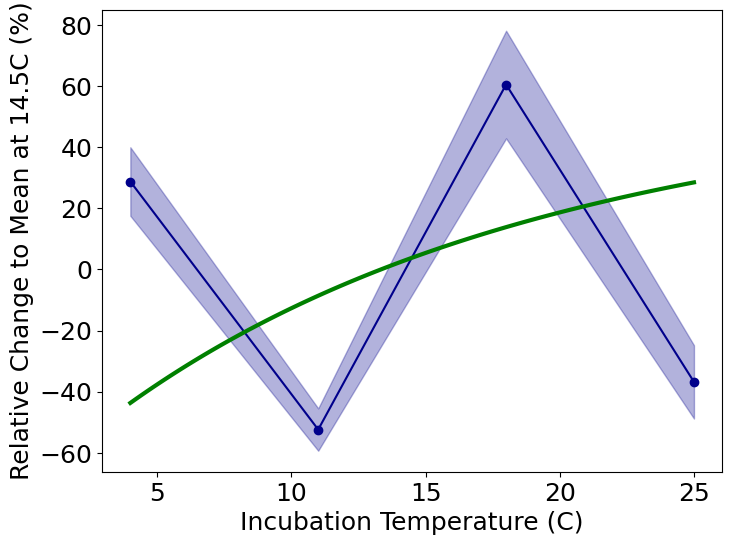

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

# Load the data
data = pd.read_excel("./enzyme_activity_combined.xlsx")

# Filter and prepare the data for each sample containing '-4+', '-11+', '-18+', and '-25+'
samples = ['-4+', '-11+', '-18+', '-25+']
incub_temps = [4, 11, 18, 25]

filtered_data_nag = []

for sample, incub_temp in zip(samples, incub_temps):
    temp_data = data[data['sample'].str.contains(f'{sample}') & ~data['sample'].str.contains(f'{sample[:-1]}-')]
    temp_data = temp_data[['assay_temp', 'PHOS', 'total_biomass']]
    temp_data['PHOS'] = temp_data['PHOS'].apply(lambda x: max(x, 0))
    temp_data['incub_temp'] = incub_temp
    temp_data['PHOS/total_biomass'] = temp_data['PHOS'] / temp_data['total_biomass']
    filtered_data_nag.append(temp_data)

# Combine the filtered data
combined_data_nag = pd.concat(filtered_data_nag)

# Define the equation A * exp(-Ea / (R * x + 273.15))
def func(x, A, Ea):
    R = 8.314
    return A * np.exp(-Ea / (R * (x + 273.15)))

# Define the function to calculate the prediction interval
def prediction_interval(x, func, popt, pcov, alpha=0.05):
    y_fit = func(x, *popt)
    n = len(y_data)    # number of data points
    p = len(popt)      # number of parameters
    dof = max(0, n - p)  # degrees of freedom

    # Student-t value for the dof and confidence level
    tval = t.ppf(1.0 - alpha / 2.0, dof)

    # Calculate the standard deviation of the residuals
    residuals = y_data - func(x_data, *popt)
    s_err = np.sqrt(np.sum(residuals**2) / dof)

    # Create the confidence interval
    ci = tval * s_err * np.sqrt(1/n + (x - np.mean(x_data))**2 / np.sum((x_data - np.mean(x_data))**2))
    return y_fit - ci, y_fit + ci

# Step 1: Calculate Enz/total_biomass at assay_temp = 14.5 for each incubation temperature using the fitted curves
assay_temp_15 = 14.5
nag_at_15 = []

for temp in [4, 11, 18, 25]:
    # Filter the data for the specific incubation temperature
    data_temp = combined_data_nag[combined_data_nag['incub_temp'] == temp]
    
    # Prepare data for curve fitting
    x_data = data_temp['assay_temp']
    y_data = data_temp['PHOS/total_biomass']
    
    # Perform curve fitting
    popt, pcov = curve_fit(func, x_data, y_data)
    
    # Calculate the value at assay_temp = 15
    nag_value = func(assay_temp_15, *popt)
    nag_at_15.append(nag_value)

# Calculate the mean of the 4 values
mean_nag_at_15 = np.mean(nag_at_15)

# Calculate the relative change to the mean
relative_change = [(value - mean_nag_at_15) / mean_nag_at_15 * 100 for value in nag_at_15]

# Step 2: Calculate Confidence Intervals at 15°C for Each Incubation Temperature
ci_at_15 = []

for temp in [4, 11, 18, 25]:
    # Filter the data for the specific incubation temperature
    data_temp = combined_data_nag[combined_data_nag['incub_temp'] == temp]
    
    # Prepare data for curve fitting
    x_data = data_temp['assay_temp']
    y_data = data_temp['PHOS/total_biomass']
    
    # Perform curve fitting
    popt, pcov = curve_fit(func, x_data, y_data)
    
    # Calculate the confidence interval at assay_temp = 15
    lower_15, upper_15 = prediction_interval(np.array([assay_temp_15]), func, popt, pcov)
    ci_at_15.append((lower_15[0], upper_15[0]))

# Calculate the mean of the lower and upper bounds
mean_lower = np.mean([ci[0] for ci in ci_at_15])
mean_upper = np.mean([ci[1] for ci in ci_at_15])

# Step 3: Compute Confidence Intervals for the Relative Change
relative_change_lower = [((ci[0] - mean_nag_at_15) / mean_nag_at_15) * 100 for ci in ci_at_15]
relative_change_upper = [((ci[1] - mean_nag_at_15) / mean_nag_at_15) * 100 for ci in ci_at_15]

# Define the parameters for φ*(T)
dM = 2e-4
γM = 0.31
c0 = 1.17
V0U = 1e5
EvU = 38
R_new = 8.314e-3  # Adjusted value of R

# Define a continuous temperature range for the second plot
temperature_range_continuous = np.linspace(4, 25, 100)

# Calculate φ*(T) for the continuous temperature range
phi_star_T_continuous = 1 - dM / (γM * V0U * np.exp(-(EvU / (R_new * (temperature_range_continuous + 273))))) - 1 / c0

# Calculate the mean φ*(T) across the continuous temperature range
phi_star_T_mean_continuous = np.mean(phi_star_T_continuous)

# Calculate the relative change to the mean for φ*(T) across the continuous temperature range
relative_change_phi_star_T_continuous = [(value - phi_star_T_mean_continuous) / phi_star_T_mean_continuous * 100 for value in phi_star_T_continuous]

# Plot relative change as a function of incubation temperature with confidence intervals and φ*(T) as a continuous function
plt.figure(figsize=(8, 6))
plt.plot([4, 11, 18, 25], relative_change, 'o-', color='darkblue', label='Relative Change')
plt.fill_between([4, 11, 18, 25], relative_change_lower, relative_change_upper, color='darkblue', alpha=0.3, label='Confidence Interval')
plt.plot(temperature_range_continuous, relative_change_phi_star_T_continuous, '-', color='green', label='Relative Change φ*(T) (Continuous)', linewidth=3)
plt.xlabel('Incubation Temperature (C)', fontsize=18)
plt.ylabel('Relative Change to Mean at 14.5C (%)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Fit Arrhenius on exponential directly

/Users/elsa/anaconda3/envs/dmenv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


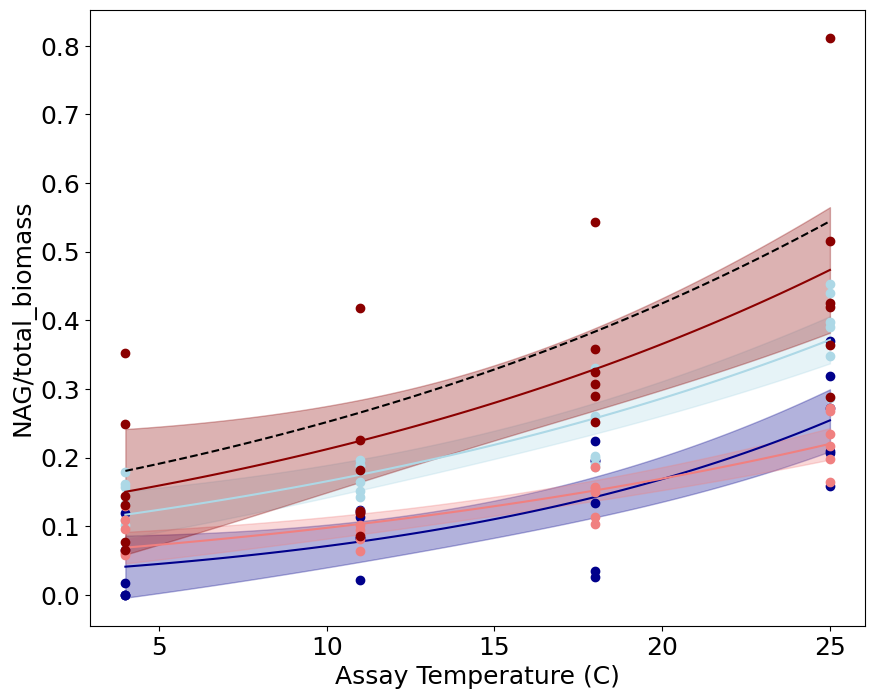

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

# Load your data
data = pd.read_excel("./enzyme_activity_combined.xlsx")

# Filter and prepare the data for each sample containing '-4+', '-11+', '-18+', and '-25+'
samples = ['-4+', '-11+', '-18+', '-25+']
incub_temps = [4, 11, 18, 25]

filtered_data = []

for sample, incub_temp in zip(samples, incub_temps):
    temp_data = data[data['sample'].str.contains(f'{sample}') & ~data['sample'].str.contains(f'{sample[:-1]}-')]
    temp_data = temp_data[['assay_temp', 'NAG', 'total_biomass']]
    temp_data['NAG'] = temp_data['NAG'].apply(lambda x: max(x, 0))
    temp_data['incub_temp'] = incub_temp
    temp_data['NAG/total_biomass'] = temp_data['NAG'] / temp_data['total_biomass']
    filtered_data.append(temp_data)

# Combine the filtered data
combined_data = pd.concat(filtered_data)

# Define the equation A * exp(-Ea / (R * x + 273.15))
def func(x, A, Ea):
    R = 8.314
    return A * np.exp(-Ea / (R * (x + 273.15)))

# Define the function to calculate the prediction interval
def prediction_interval(x, func, popt, pcov, alpha=0.05):
    y_fit = func(x, *popt)
    n = len(y_data)    # number of data points
    p = len(popt)      # number of parameters
    dof = max(0, n - p)  # degrees of freedom

    # Student-t value for the dof and confidence level
    tval = t.ppf(1.0 - alpha / 2.0, dof)

    # Calculate the standard deviation of the residuals
    residuals = y_data - func(x_data, *popt)
    s_err = np.sqrt(np.sum(residuals**2) / dof)

    # Create the confidence interval
    ci = tval * s_err * np.sqrt(1/n + (x - np.mean(x_data))**2 / np.sum((x_data - np.mean(x_data))**2))
    return y_fit - ci, y_fit + ci

# Define the color map for different incub_temp
color_map = {4: 'darkblue', 11: 'lightblue', 18: 'lightcoral', 25: 'darkred'}

# Prepare the plot
plt.figure(figsize=(10, 8))

# Iterate over each incubation temperature
for temp in [4, 11, 18, 25]:
    # Filter the data for the specific incubation temperature
    data_temp = combined_data[combined_data['incub_temp'] == temp]
    
    # Prepare data for curve fitting
    x_data = data_temp['assay_temp']
    y_data = data_temp['NAG/total_biomass']
    
    # Perform curve fitting
    popt, pcov = curve_fit(func, x_data, y_data)
    
    # Generate the fitted curve and prediction interval
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = func(x_fit, *popt)
    lower, upper = prediction_interval(x_fit, func, popt, pcov)
    
    # Plot data points, fit, and prediction interval
    plt.plot(x_data, y_data, 'o', color=color_map[temp], label=f'Data (Incub Temp = {temp})')
    plt.plot(x_fit, y_fit, '-', color=color_map[temp], label=f'Fit (Incub Temp = {temp})')
    plt.fill_between(x_fit, lower, upper, color=color_map[temp], alpha=0.3)
    
# Add the 5th plot with specific parameters
# Define the given Ea and A values
Ea_fixed = 36.1 * 1000  # in J/mol
A_fixed = 1.15e6
# Generate the fitted curve for the given parameters
y_fixed = func(x_fit, A_fixed, Ea_fixed)
# Plot the fixed curve
plt.plot(x_fit, y_fixed, 'k--', label='Fixed Fit (Ea=36.1kJ/mol, A=1.15e6)')

# Customize the plot
plt.xlabel('Assay Temperature (C)',fontsize=18)
plt.ylabel('NAG/total_biomass',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Comparison with my model - relative change to mean

relative_enz_biomass= [-0.6500079484270969, 0.328503494845863, -0.2243022282719555, 0.5458066818531893]


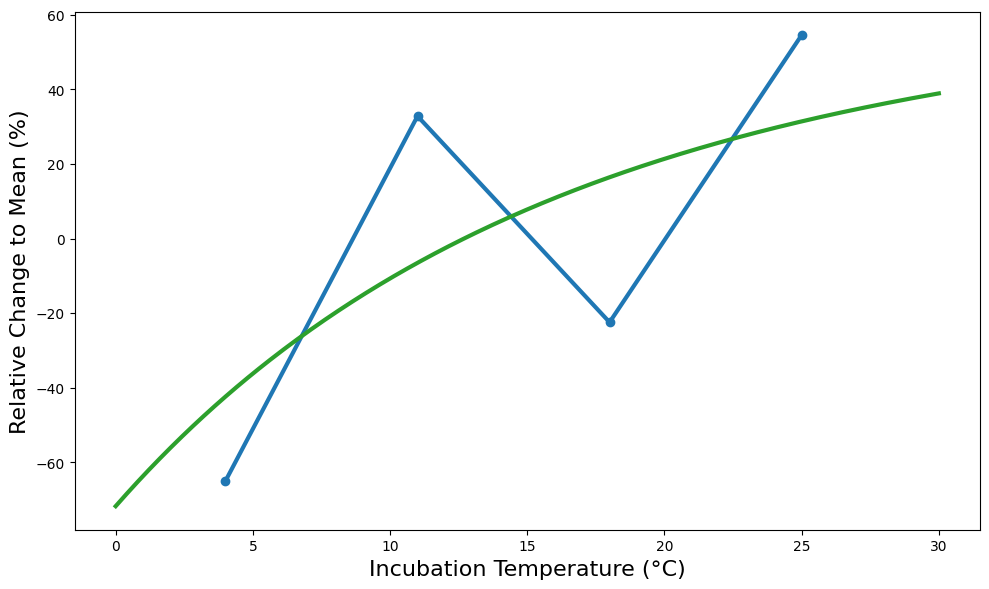

In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='openpyxl')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Load data
data = pd.read_excel("./enzyme_activity_combined.xlsx")

# Constants
R = 8.314  # J/(mol·K)

# Function to model: y = (-Ea / R) * x + log_A
def arrhenius(x, Ea, log_A):
    return (-Ea / R) * x + log_A

# Preprocess and replace negative values and '#DIV/0!' with 0.01
def preprocess_values(value):
    if value == '#DIV/0!' or value == 0 or value < 0:
        return 0.01
    return value

# Function to filter and process data
def prepare_plot_data(sample_contains, enzyme_activity):
    filtered_data = data[data['sample'].str.contains(sample_contains, regex=False)].copy()
    filtered_data[enzyme_activity] = filtered_data[enzyme_activity].apply(preprocess_values)
    filtered_data['assay_temp_K'] = filtered_data['assay_temp'] + 273.15
    filtered_data['ln_activity'] = np.log(filtered_data[enzyme_activity].astype(float) / filtered_data['total_biomass'])
    filtered_data['inverse_assay_temp_K'] = 1 / filtered_data['assay_temp_K']
    filtered_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    filtered_data.dropna(subset=['ln_activity', 'inverse_assay_temp_K'], inplace=True)

    x_data = filtered_data['inverse_assay_temp_K']
    y_data = filtered_data['ln_activity']
    results = {}
    if not x_data.empty and not y_data.empty:
        try:
            popt, pcov = curve_fit(arrhenius, x_data, y_data)
            Ea, log_A = popt
            A = np.exp(log_A)
            r_squared = r2_score(y_data, arrhenius(x_data, *popt))
            results = {"Ea": Ea, "A": A, "R_squared": r_squared}
        except RuntimeError as e:
            results = {"error": str(e)}
    else:
        results = {"error": "Data is empty or contains NaN/inf values"}
    return results

# Prepare data for each sample
samples = ['-4+', '-11+', '-18+', '-25+']        # Keeps +L only, and separate into the 4 incubation temperatures
results = [prepare_plot_data(sample, 'NAG') for sample in samples]

# Function to calculate y using the Arrhenius equation
def arrhenius_equation(A, Ea, T):
    return A * np.exp(-Ea / (R * T))

# Extract Enz/Biomass at T=15°C
T_extract = 15 + 273.15  # Convert to Kelvin
enz_biomass_extract = []

for result in results:
    if "error" not in result:
        enz_biomass_extract.append(arrhenius_equation(result['A'], result['Ea'], T_extract))

# Plot the extracted Enz/Biomass values at ref T
incubation_temperatures = [4, 11, 18, 25]

# Calculate relative change to the mean for Enz/Biomass Intercept
mean_enz_biomass = np.mean(enz_biomass_extract)
relative_enz_biomass = [(value - mean_enz_biomass) / mean_enz_biomass for value in enz_biomass_extract]
print('relative_enz_biomass=', relative_enz_biomass)

# Define the parameters for φ*(T)
dM = 2e-4
γM = 0.31
c0 = 1.17
V0U = 1e5
EvU = 38
R_new = 8.314e-3  # Adjusted value of R

# Calculate φ*(T) using the provided equation
temperature_range_line = np.linspace(0, 30, 300)
phi_star_T = 1 - dM / (γM * V0U * np.exp(-(EvU / (R_new * (temperature_range_line + 273))))) - 1 / c0

# Calculate relative change to the mean for φ*(T)
mean_phi_star_T = np.mean(phi_star_T)
relative_phi_star_T = [(value - mean_phi_star_T) / mean_phi_star_T for value in phi_star_T]

# Create the plot with the relative changes on a single y-axis, with percentage units
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Incubation Temperature (°C)', fontsize=16)
ax.set_ylabel('Relative Change to Mean (%)', fontsize=16)

# Convert relative changes to percentages
relative_enz_biomass_percent = [value * 100 for value in relative_enz_biomass]
relative_phi_star_T_percent = [value * 100 for value in relative_phi_star_T]

# Plotting relative Enz/Biomass Intercept
ax.plot(incubation_temperatures, relative_enz_biomass_percent, marker='o', linestyle='-', color='tab:blue', label='Relative NAG/Biomass Intercept', linewidth=3)

# Plotting relative Theoretical Optimal Enzyme Allocation
ax.plot(temperature_range_line, relative_phi_star_T_percent, color='tab:green', label='Relative Theoretical Optimal Enzyme Allocation', linewidth=3)

ax.tick_params(axis='y')
#ax.legend(loc='best')

fig.tight_layout()
plt.show()

In [8]:
np.mean([0.05757266265301209, 0.21853491585987225, 0.1276000010048498, 0.25428065072091444])

0.16449705755966215

# Arrhenius per enzyme

/Users/elsa/anaconda3/envs/dmenv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


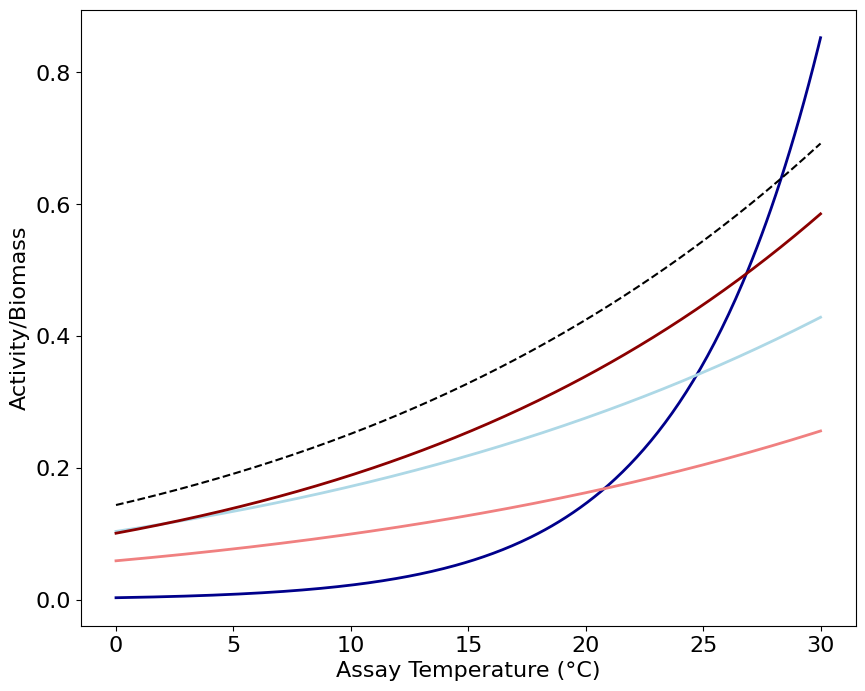

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Load data
data = pd.read_excel("./enzyme_activity_combined.xlsx")

# Constants
R = 8.314  # J/(mol·K)

# Function to model: y = (-Ea / R) * x + log_A
def arrhenius(x, Ea, log_A):
    return (-Ea / R) * x + log_A

# Preprocess and replace negative values and '#DIV/0!' with 0.01
def preprocess_values(value):
    if value == '#DIV/0!' or value == 0 or value < 0:
        return 0.01
    return value

# Function to filter and process data
def prepare_plot_data(sample_contains, enzyme_activity):
    filtered_data = data[data['sample'].str.contains(sample_contains, regex=False)].copy()
    filtered_data[enzyme_activity] = filtered_data[enzyme_activity].apply(preprocess_values)
    filtered_data['assay_temp_K'] = filtered_data['assay_temp'] + 273.15   # Convert temperatures in Kelvin
    filtered_data['ln_activity'] = np.log(filtered_data[enzyme_activity].astype(float) / filtered_data['total_biomass'])   #Calculate ln(activity/biomass)
    filtered_data['inverse_assay_temp_K'] = 1 / filtered_data['assay_temp_K']   #Take 1/T
    filtered_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    filtered_data.dropna(subset=['ln_activity', 'inverse_assay_temp_K'], inplace=True)

    x_data = filtered_data['inverse_assay_temp_K']
    y_data = filtered_data['ln_activity']
    results = {}
    if not x_data.empty and not y_data.empty:
        try:
            popt, pcov = curve_fit(arrhenius, x_data, y_data)
            Ea, log_A = popt
            A = np.exp(log_A)
            r_squared = r2_score(y_data, arrhenius(x_data, *popt))
            results = {"Ea": Ea, "A": A, "R_squared": r_squared}
        except RuntimeError as e:
            results = {"error": str(e)}
    else:
        results = {"error": "Data is empty or contains NaN/inf values"}
    return results

# Prepare data for each sample
samples = ['-4+', '-11+', '-18+', '-25+']        # Keeps +L only, and separate into the 4 incubation temperatures
results = [prepare_plot_data(sample, 'NAG') for sample in samples]

# Plot settings
T_celsius = np.linspace(0, 30, 300)  # Temperature range from 0 to 30 degrees Celsius
T_kelvin = T_celsius + 273.15        # Convert to Kelvin

plt.figure(figsize=(10, 8))
colors = ['darkblue', 'lightblue', 'lightcoral', 'darkred']
labels = ['-4-', '-11-', '-18-', '-25-']

# Function to calculate y using the Arrhenius equation
def arrhenius_equation(A, Ea, T):
    return A * np.exp(-Ea / (R * T))

# Plotting
for result, color, label in zip(results, colors, labels):
    if "error" not in result:
        y_values = arrhenius_equation(result['A'], result['Ea'], T_kelvin)
        plt.plot(T_celsius, y_values, color=color, label=f'Sample {label}',linewidth=2)

# Add the 5th plot with specific parameters
Ea_new = 36.1 * 1000  # Convert from kJ/mol to J/mol
A_new = 1.15e6
y_values_new = arrhenius_equation(A_new, Ea_new, T_kelvin)
plt.plot(T_celsius, y_values_new, 'k--', label='Model parameters')

plt.xlabel('Assay Temperature (°C)', fontsize=16)
plt.ylabel('Activity/Biomass', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend()
#plt.grid(True)
plt.show()


# Linearized Arrhenius

/Users/elsa/anaconda3/envs/dmenv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


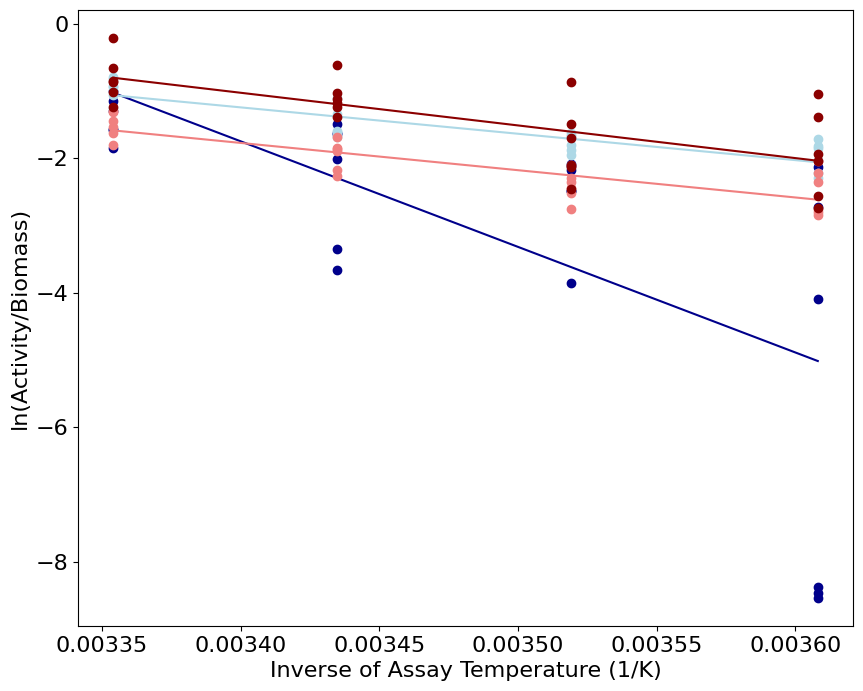

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the data from the uploaded file
data = pd.read_excel("./enzyme_activity_combined.xlsx")

# Constants
R = 8.314  # J/(mol·K)

# Function to model: y = (-Ea / R) * x + log_A
def arrhenius(x, Ea, log_A):
    return (-Ea / R) * x + log_A

# Preprocess and replace negative values and '#DIV/0!' with 0.01
def preprocess_values(value):
    return 0.01 if value == '#DIV/0!' or value <= 0 else value

# General function to process and fit data for any sample
def process_and_fit(sample_contains, color, label):
    filtered_data = data[data['sample'].str.contains(sample_contains, regex=False)].copy()
    filtered_data['NAG'] = filtered_data['NAG'].apply(preprocess_values)
    filtered_data['assay_temp_K'] = filtered_data['assay_temp'] + 273.15
    filtered_data['ln_activity'] = np.log(filtered_data['NAG'].astype(float) / filtered_data['total_biomass'])
    filtered_data['inverse_assay_temp_K'] = 1 / filtered_data['assay_temp_K']
    filtered_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    filtered_data.dropna(subset=['ln_activity', 'inverse_assay_temp_K'], inplace=True)
    
    # Perform curve fitting
    x_data = filtered_data['inverse_assay_temp_K']
    y_data = filtered_data['ln_activity']
    popt, _ = curve_fit(arrhenius, x_data, y_data)
    Ea, log_A = popt
    A = np.exp(log_A)
    
    # Plot data points and fitted line
    plt.plot(x_data, y_data, 'o', color=color, label=f'{label} Data Points')
    x_fit = np.linspace(min(x_data), max(x_data), 300)
    y_fit = arrhenius(x_fit, Ea, log_A)
    plt.plot(x_fit, y_fit, '-', color=color, label=f'{label} Fitted Arrhenius Line\nEa = {Ea:.2f} J/mol, A = {A:.2e}')

# Plot settings
plt.figure(figsize=(10, 8))

# Process and plot for each sample with different colors
samples = [
    ('-4+', 'darkblue', '-4+'),
    ('-11+', 'lightblue', '-11+'),
    ('-18+', 'lightcoral', '-18+'),
    ('-25+', 'darkred', '-25+')
]

for sample, color, label in samples:
    process_and_fit(sample, color, label)

# Final plot adjustments
plt.xlabel('Inverse of Assay Temperature (1/K)', fontsize=16)
plt.ylabel('ln(Activity/Biomass)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()